## Prepare

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-02-16 12:13:26.608948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval
import os

/home/stat/anaconda3/envs/MOE/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/home/stat/anaconda3/envs/MOE/lib/python3.8/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [3]:
subject_name = "anna_vs_carla"


In [4]:
# File paths
train_data_file = f'./PASTA_data/new_processed_data/{subject_name}_train.csv'
test_data_file = f'./PASTA_data/new_processed_data/{subject_name}_test.csv'

os.makedirs('./PASTA-Models/', exist_ok=True)

# Load dataset
df = pd.read_csv(train_data_file)
df.rename(columns={df.columns[0]: "Sentence"}, inplace=True)

# 
print('Unique comments: ', df.Sentence.nunique() == df.shape[0])
print('Null values: ', df.isnull().values.any())
print('Average sentence length: ', df.Sentence.str.split().str.len().mean())
print('Standard deviation of sentence length: ', df.Sentence.str.split().str.len().std())
print('df.shape: ', df.shape)

Unique comments:  False
Null values:  False
Average sentence length:  47.78848167539267
Standard deviation of sentence length:  30.85458681568248
df.shape:  (955, 5)


In [5]:
# Extract label columns
cols = df.columns
label_cols = list(cols[1:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)
print('Count of 1 per label: \n', df[label_cols].sum(), '\n')
print('Count of 0 per label: \n', df[label_cols].eq(0).sum())

df['one_hot_labels'] = list(df[label_cols].values)

labels = list(df.one_hot_labels.values)
comments = list(df.Sentence.values)

# Tokenizer 
max_length = 100
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encodings = tokenizer.batch_encode_plus(comments, max_length=max_length, padding=True, truncation=True)

input_ids = encodings['input_ids']
token_type_ids = encodings['token_type_ids']
attention_masks = encodings['attention_mask']

label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts == 1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)

print('df label indices with only one instance: ', one_freq_idxs)

# Extract single-instance inputs
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

/home/stat/anaconda3/envs/MOE/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading file vocab.txt from cache at /home/stat/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/stat/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading configuration file config.json from cache at /home/stat/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architec

Label columns:  ['E1', 'E2', 'E4', 'E5']
Count of 1 per label: 
 E1    785
E2     54
E4    159
E5     33
dtype: int64 

Count of 0 per label: 
 E1    170
E2    901
E4    796
E5    922
dtype: int64


df label indices with only one instance:  []


In [6]:
# Train-test split
train_inputs, validation_inputs, train_masks, validation_masks, train_token_types, validation_token_types, train_labels, validation_labels = train_test_split(
    input_ids, attention_masks, token_type_ids, labels, random_state=2020, test_size=0.10, stratify=labels)

# Add one-frequency data to training set
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert to torch tensors
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.float)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels, dtype=torch.float)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

# 
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels, problem_type="multi_label_classification")

# Define optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=True)

/tmp/ipykernel_10770/2335890723.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_labels = torch.tensor(train_labels, dtype=torch.float)
/home/stat/anaconda3/envs/MOE/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading configuration file config.json from cache at /home/stat/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpo

# Training

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 0.4249
Validation Loss: 0.3284


Epoch:   5%|▌         | 1/20 [05:19<1:41:15, 319.74s/it]

Best model saved!
Epoch 2/20 - Train Loss: 0.3096
Validation Loss: 0.2781


Epoch:  10%|█         | 2/20 [10:38<1:35:47, 319.30s/it]

Best model saved!
Epoch 3/20 - Train Loss: 0.2587
Validation Loss: 0.2304


Epoch:  15%|█▌        | 3/20 [16:00<1:30:48, 320.52s/it]

Best model saved!
Epoch 4/20 - Train Loss: 0.2147
Validation Loss: 0.1938


Epoch:  20%|██        | 4/20 [21:11<1:24:26, 316.67s/it]

Best model saved!
Epoch 5/20 - Train Loss: 0.1684
Validation Loss: 0.1922


Epoch:  25%|██▌       | 5/20 [27:30<1:24:47, 339.16s/it]

Best model saved!
Epoch 6/20 - Train Loss: 0.1414
Validation Loss: 0.1603


Epoch:  30%|███       | 6/20 [34:32<1:25:41, 367.24s/it]

Best model saved!
Epoch 7/20 - Train Loss: 0.1137
Validation Loss: 0.1485


Epoch:  35%|███▌      | 7/20 [41:39<1:23:50, 386.98s/it]

Best model saved!
Epoch 8/20 - Train Loss: 0.0961


Epoch:  40%|████      | 8/20 [48:43<1:19:44, 398.73s/it]

Validation Loss: 0.1539
Epoch 9/20 - Train Loss: 0.0813
Validation Loss: 0.1342


Epoch:  45%|████▌     | 9/20 [54:22<1:09:40, 380.06s/it]

Best model saved!
Epoch 10/20 - Train Loss: 0.0760


Epoch:  50%|█████     | 10/20 [59:04<58:17, 349.74s/it] 

Validation Loss: 0.1626
Epoch 11/20 - Train Loss: 0.0635


Epoch:  55%|█████▌    | 11/20 [1:01:30<43:05, 287.31s/it]

Validation Loss: 0.1345
Epoch 12/20 - Train Loss: 0.0540


Epoch:  55%|█████▌    | 11/20 [1:05:13<53:21, 355.74s/it]

Validation Loss: 0.1395
Early stopping triggered! Training stopped.


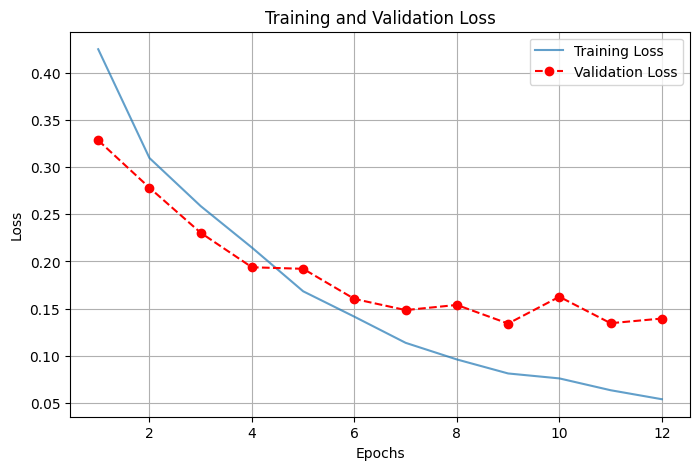

In [7]:
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.metrics import f1_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

output_model_name = './PASTA-Models/best_model_{}.pt'.format(subject_name)

#
patience = 3  
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []  
val_losses = []  
epochs = 20  
loss_func = torch.nn.BCEWithLogitsLoss()  

for epoch in trange(epochs, desc="Epoch"):
    # Training
    model.train()
    tr_loss = 0  
    nb_tr_steps = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)  
        b_input_ids, b_input_mask, b_labels, b_token_types = batch

        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=b_token_types, attention_mask=b_input_mask)
        logits = outputs[0]

        loss = loss_func(logits.view(-1, num_labels), b_labels.type_as(logits).view(-1, num_labels))

        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_steps += 1

    avg_train_loss = tr_loss / nb_tr_steps
    train_losses.append(avg_train_loss)  
    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)  
        b_input_ids, b_input_mask, b_labels, b_token_types = batch

        with torch.no_grad():
            outs = model(b_input_ids, token_type_ids=b_token_types, attention_mask=b_input_mask)
            b_logit_pred = outs[0]

            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)  
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), output_model_name)  # Save best model
        print("Best model saved!")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered! Training stopped.")
        break  



# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', alpha=0.7)
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o', linestyle='dashed', color='red')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Testing

In [8]:
# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels, problem_type="multi_label_classification")
model_file = './PASTA-Models/best_model_{}.pt'.format(subject_name)
model.load_state_dict(torch.load(model_file, map_location=device))

model.to(device)
model.eval()  

torch.save(model, './Models/best_model_{}.pt'.format(subject_name))

/home/stat/anaconda3/envs/MOE/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading configuration file config.json from cache at /home/stat/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps":

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [11]:
## Load and Preprocess Test Data
test_df = pd.read_csv(test_data_file)  
test_label_cols = list(test_df.columns[1:])

# Check data integrity
print('Null values:', test_df.isnull().values.any())  
print('Same columns between train and test:', label_cols == test_label_cols)  

test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)].copy()  

test_df['one_hot_labels'] = test_df[test_label_cols].values.tolist()
test_df.rename(columns={test_df.columns[0]: "Sentence"}, inplace=True)

test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.Sentence.values)

# Tokenization
test_encodings = tokenizer.batch_encode_plus(
    test_comments, max_length=max_length, padding=True, truncation=True  # ✅ Fix deprecated `pad_to_max_length`
)

test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels, dtype=torch.float)  # ✅ Convert to float tensor for BCEWithLogitsLoss
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)

test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# 
logit_preds, true_labels, pred_labels, tokenized_texts = [], [], [], []

model.eval() 
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)  
    b_input_ids, b_input_mask, b_labels, b_token_types = batch

    with torch.no_grad():
        outs = model(b_input_ids, token_type_ids=b_token_types, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.cpu().numpy()
        pred_label = pred_label.cpu().numpy()
        b_labels = b_labels.cpu().numpy()

    tokenized_texts.append(b_input_ids.tolist())  
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# 
pred_labels = np.vstack(pred_labels)  
true_labels = np.vstack(true_labels)

# Convert to boolean
true_bools = (true_labels == 1)
pred_bools = (pred_labels > 0.5)

# Ensure same shape before computing exact match
assert pred_bools.shape == true_bools.shape, "Shape mismatch in predictions and true labels!"

# Compute Metrics
f1_acc = f1_score(true_bools, pred_bools, average='micro')  # Micro F1-score
macro_f1 = f1_score(true_bools, pred_bools, average='macro') # Macro F1 score
exact_match = np.mean(np.all(pred_bools == true_bools, axis=1))  # Exact match accuracy
per_label_accuracy = np.mean(pred_bools == true_bools)  # Per-label accuracy

# Print results
print(f"Test Micro F1 Score: {f1_acc:.6f}")
print(f"Test Macro F1 Score: {macro_f1:.6f}")
print(f"Exact Match Accuracy: {exact_match:.6f}")
print(f"Per-Label Accuracy: {per_label_accuracy:.6f}\n")


Null values: False
Same columns between train and test: True
Test Micro F1 Score: 0.885880
Test Macro F1 Score: 0.563622
Exact Match Accuracy: 0.811715
Per-Label Accuracy: 0.938285

